## Set-up

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

from pprint import pprint
import re
from tqdm import tqdm
tqdm.pandas()
import numpy as np

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
#!pwd
import os

# Google Bucket
# file name checkpoint_0512_sent_split.parquet
path_bucket = 'gs://msca-sp23-bucket/nlp_data'
path_bucket_df_cleaned = path_bucket + '/' + 'df_cleaned_0514.parquet'
runtime_path = '/home/jupyter/data/nlp_final'

os.chdir(runtime_path)
print(os.getcwd())

/home/jupyter/data/nlp_final


In [3]:
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

import warnings
warnings.filterwarnings("ignore")

In [4]:
import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [5]:
import nltk as nltk
from nltk.corpus import stopwords

import multiprocessing

In [6]:
import spacy
import spacy.cli
spacy.cli.download("en_core_web_md")
nlp = spacy.load("en_core_web_md")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 31.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [7]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/anthony/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/anthony/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/anthony/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/anthony/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/anthony/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
# read data
df_raw = pd.read_parquet(path_bucket_df_cleaned, engine='pyarrow')

# take a sample
df = df_raw.sample(50000, random_state=42)
print(df.shape)
df.head(1)

(50000, 5)


,url,date,title,text_split,text
158935,https://cio.economictimes.indiatimes.com/news/business-analytics/anil-kumar-aays-analytics-on-how-large-enterprises-are-democratising-data-science-ml-in-the-corporate-finance-space/96214109,2022-12-14,"Anil Kumar, Aays Analytics on how large enterprises are democratising data science, ML in the corporate finance space, CIO News, ET CIO","[Accept the updated privacy cookie policy Dear user, ET CIO privacy and cookie policy has been updated to align with the new data regulations in European Union. Please review and accept these changes below to continue using the website.You can see our privacy policy our cookie policy. We use cookies to ensure the best experience for you on our website.If you choose to ignore this message, we'll assume that you are happy to receive all cookies on ET CIO. AnalyticsNecessaryNewsletter Name...","Accept the updated privacy cookie policy Dear user, ET CIO privacy and cookie policy has been updated to align with the new data regulations in European Union. Please review and accept these changes below to continue using the website.You can see our privacy policy our cookie policy. We use cookies to ensure the best experience for you on our website.If you choose to ignore this message, we'll assume that you are happy to receive all cookies on ET CIO. AnalyticsNecessaryNewsletter NameP..."


## LDA, on overall topics

### Text Prep

I want to utilize parallelization as much as possile to save time

Helper Functions

In [9]:
%%time

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

# Define functions for stopwords, bigrams, trigrams and lemmatization
stop_words = stopwords.words('english')
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

CPU times: user 2.49 ms, sys: 0 ns, total: 2.49 ms
Wall time: 1.64 ms


In [10]:
# select the text
df_text = df[['text']]
#df_title = df['title']

# remove punctuation and numbers using parallel_apply
df_text['text_cleaned'] = df_text['text'].parallel_apply(lambda x: re.sub('[^A-Za-z]+', ' ', x))
#df_title['title_cleaned'] = df_title.parallel_apply(lambda x: re.sub('[^A-Za-z]+', ' ', x))

In [11]:
# drop na and duplicates
df_text = df_text.dropna().drop_duplicates()
# convert to str type
df_text['text_cleaned'] = df_text['text_cleaned'].astype(str)
df_text.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49865 entries, 158935 to 90694
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          49865 non-null  object
 1   text_cleaned  49865 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [12]:
# save a copy
df_text_before = df_text.copy()

# define a function to handle errors
def handle_errors(func):
    def wrapper(x):
        try:
            return func(x)
        except Exception as e:
            print(f"Error processing row: {x}")
            return np.nan
    return wrapper

# define the remove_stopwords function with the handle_errors decorator
@handle_errors
def remove_stopwords(row): 
    return [i for i in simple_preprocess(row) if i not in stopwords.words('english')]

# apply remove_stopwords function with try/except
df_text['text_cleaned'] = df_text['text_cleaned'].parallel_apply(remove_stopwords)

In [13]:
df_text.head()

,text,text_cleaned
158935,"Accept the updated privacy cookie policy Dear user, ET CIO privacy and cookie policy has been updated to align with the new data regulations in European Union. Please review and accept these changes below to continue using the website.You can see our privacy policy our cookie policy. We use cookies to ensure the best experience for you on our website.If you choose to ignore this message, we'll assume that you are happy to receive all cookies on ET CIO. AnalyticsNecessaryNewsletter NameP...","[accept, updated, privacy, cookie, policy, dear, user, et, cio, privacy, cookie, policy, updated, align, new, data, regulations, european, union, please, review, accept, changes, continue, using, website, see, privacy, policy, cookie, policy, use, cookies, ensure, best, experience, website, choose, ignore, message, assume, happy, receive, cookies, et, cio, google, analyticsgoogle, yearhttpsto, track, visitors, site, origin, behaviour, ibeat, analyticsibeat, yearhttpsto, track, article, yearh..."
77297,"Skip to contentWeatherCOVID 19 CoverageWho's HiringLivestreamElection PodcastHomeElection ResultsNewsAPContestsNationalWildlife WatchWCAX News Livestream WeatherClosingsRadarSki Board ReportWeather CamsWCAX Weather AppWeather FAQWeather FeaturesAstronomySportsCommunity CalendarContact UsMeet the TeamAdvertise With UsCommunity PartnersGot a Story Idea?Order Channel 3 News StoriesWCAX JobsPaid InternshipsStream News Live and On DemandNewsletterECHO, Leahy Center for Lake ChamplainJumpOnITVid...","[skip, coveragewho, watchwcax, news, livestream, board, reportweather, camswcax, weather, appweather, faqweather, calendarcontact, usmeet, teamadvertise, uscommunity, partnersgot, story, idea, order, channel, news, storieswcax, jobspaid, news, live, leahy, center, lake, resultscovid, mapfoodbankshow, watch, listingssubmit, photos, videoscircle, country, music, lifestylegray, dc, fencebuy, vermont, firstmade, vermontbusiness, breaksuper, seniorsyou, quote, melatest, newscastspress, releases, ..."
99045,Nvidia puts AI at center of latest GeForce graphics card upgrade The Seattle Times Traffic Lab Law Justice Local Politics Education Education Lab Eastside Environment Health Data Mental Health Project Homeless Times Watchdog Boeing Aerospace Amazon Microsoft Technology Real Estate Economy Artificial Intelligence Seahawks Mariners Huskies Cougars Storm Sounders Kraken Reign High School Sports On TV/Radio Movies Books Music Theater Classical Music TV/Streaming Comics Games Puzzles H...,"[nvidia, puts, ai, center, latest, geforce, graphics, card, upgrade, seattle, times, traffic, lab, law, justice, local, politics, education, education, lab, eastside, environment, health, data, mental, health, project, homeless, times, watchdog, boeing, aerospace, amazon, microsoft, technology, real, estate, economy, artificial, intelligence, seahawks, mariners, huskies, cougars, storm, sounders, kraken, reign, high, school, sports, tv, radio, movies, books, music, theater, classical, music,..."
79651,"BusinessTechnologyWorldNationalPoliticsMedia CultureOpinionSportsSocial CapitalCryptoListings MoreSpotlightGlossaryEditionsAustralia EditionIndia EditionInternational EditionSingapore EditionUnited KingdomUnited StatesNEWSLETTERFollow Us KEY POINTSThe beta version of SK 's ""A."" pronounced ""A dot"" was launched in South Korea in May 2022A. is reportedly based on generative AI just like ChatGPTSKT will reportedly integrate various services it owns into the chatbotSouth Korea's SK is ...","[editionindia, editionunited, kingdomunited, us, key, pointsthe, beta, version, sk, pronounced, dot, launched, south, korea, may, reportedly, based, generative, ai, like, chatgptskt, reportedly, integrate, various, services, owns, chatbotsouth, korea, sk, planning, year, fully, launch, artificial, intelligence, chatbot, executive, pany, said, offer, lot, booming, chatgpt, mobile, world, congress, barcelona, spain, skt, vice, president, eric, davis, told, cnbc, pan

In [14]:
# save checkpoint
checkpoint_path = '/home/jupyter/data/nlp_final'+'df_text_0514_lda.parquet'
#df_text.to_parquet(checkpoint_path, engine='pyarrow')

# read data
#df_text = pd.read_parquet(checkpoint_path, engine='pyarrow')

### titleza LDA

In [15]:
%%time
# tokenize the text
data_list = df_text['text_cleaned'].tolist()
data_tokens = list(sent_to_words(data_list))

CPU times: user 2min 8s, sys: 1.03 s, total: 2min 9s
Wall time: 2min 9s


In [16]:
%%time
# create bigrams & trigrams
bigram = gensim.models.Phrases(data_tokens, min_count=1, threshold=1)
trigram = gensim.models.Phrases(bigram[data_tokens], threshold=1)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

CPU times: user 2min 46s, sys: 1.35 s, total: 2min 47s
Wall time: 2min 47s


In [17]:
%%time
# Remove Stop Words
#data_tokens_nostops = remove_stopwords(data_tokens)

# Create n-grams
data_words_bigrams = make_bigrams(data_tokens)
data_words_trigrams = make_trigrams(data_tokens)

# Combine tokens and n-grams
# data_tokens_cobnined = data_tokens_nostops + data_words_bigrams + data_words_trigrams
data_tokens_cobnined = data_words_trigrams

# Lemmatize text keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_tokens_cobnined, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(*data_lemmatized[:1])

['cio_privacy_cookie_policy', 'updated_align_new', 'data_regulations_european_union', 'please_review_accept_change', 'use_cookies_ensure_b', 'experience_website_choose_ignore', 'message_assume_happy_receive', 'cookies_et_cio_google', 'analyticsgoogle_yearhttpsto_track_visitor', 'site_origin', 'track_article_yearhttpsto_track', 'visitors_site', 'behaviour_optouttime', 'dayhttpsstores_user', 'internet_hourshttpsto_serve_content', 'relevant_internet', 'identify_userostidtime', 'yearhttpsoauth_user', 'accross_internet_fingerprinting_uniquely', 'identify_client', 'browsers_namepurpose_daily_daily', 'list_important', 'news_security', 'news_bfsi_new', 'government_news_hospitality', 'news_et', 'travelworld_new', 'infra_new', 'news_ciosea', 'news_hrsea_news_hrme', 'news_ing_event', 'cfo_meet_discussion_revise', 'companies_act_new', 'drive', 'transformation', 'hr', 'agorajesh', 'communication', 'strategic_shift', 'cloud_first', 'cloud_smart', 'day', 'tech', 'apprentice', 'increase', 'tech', 'ent

In [27]:
checkpoint_path = '/home/jupyter/data/nlp_final'

# # save the limmatized data to txt
# path = checkpoint_path + '/' + 'data_lemmatized.txt'
# with open(path, 'w') as f:
#     for item in data_lemmatized:
#         f.write("%s\n" % item)

# read the limmatized data from txt
path = checkpoint_path + '/' + 'data_lemmatized.txt'
with open(path, 'r') as f:
    data_read = f.read().splitlines()

# read each element (a str) of data_read to a list; append to data_lemmatized
data_lemmatized = []

def string_to_list(str):
    # revemo al " and []
    str = str.replace('"', '')
    str = str.replace('\'', '')
    str = str.replace('[', '')
    str = str.replace(']', '')
    # split by ', '
    output_list = str.split(', ')
    return output_list

for i in range(len(data_read)):
    data_lemmatized.append(string_to_list(data_read[i]))

In [29]:
%%time

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(data_lemmatized)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_lemmatized]

CPU times: user 28.7 s, sys: 578 ms, total: 29.2 s
Wall time: 29.2 s


In [34]:
num_processors = multiprocessing.cpu_count()
workers = num_processors-1
print(f'Using {workers} workers')

Using 15 workers


In [20]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=100,                  
                       passes=10,
                       alpha=a,
                       eta=b,
                       workers=workers)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [35]:
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Alpha parameter
alpha = ['asymmetric'] # Run for number of topics only

# Beta parameter
beta = ['auto'] # Run for number of topics only

# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [# gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.5), 
               # gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.75), 
               doc_term_matrix]

corpus_title = ['100% Corpus']
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

In [ ]:
'''%%time 

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

# iterate through hyperparameters
for i in tqdm(range(len(corpus_sets))):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        #tic()
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                itr += 1
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary,
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')

lda_tuning = pd.DataFrame(model_results)     '''

In [36]:
from joblib import Parallel, delayed

def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = LdaMulticore(corpus=corpus,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=100,                  
                       passes=10,
                       alpha=a,
                       eta=b,
                       workers=workers)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
    return coherence_model_lda.get_coherence()

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

# iterate through hyperparameters
for i in tqdm(range(len(corpus_sets))):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        #tic()
        for a in alpha:
            # iterate through beta values
            jobs = []
            for b in beta:
                itr += 1
                # run each beta value in parallel
                job = delayed(compute_coherence_values)(corpus=corpus_sets[i], dictionary=dictionary,
                                                  k=k, a=a, b=b)
                jobs.append(job)
            # compute coherence scores in parallel and save results
            coherences = Parallel(n_jobs=min(8, len(jobs)))(jobs)
            for b, cv in zip(beta, coherences):
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
            pct_completed = round((itr / itr_total * 100),1)
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')

lda_tuning = pd.DataFrame(model_results)


LDA will execute 9 iterations


  0%|          | 0/1 [00:00<?, ?it/s]

Completed model based on 2 LDA topics. Finished 11.1% of LDA runs
Completed model based on 3 LDA topics. Finished 22.2% of LDA runs
Completed model based on 4 LDA topics. Finished 33.3% of LDA runs
Completed model based on 5 LDA topics. Finished 44.4% of LDA runs
Completed model based on 6 LDA topics. Finished 55.6% of LDA runs
Completed model based on 7 LDA topics. Finished 66.7% of LDA runs
Completed model based on 8 LDA topics. Finished 77.8% of LDA runs
Completed model based on 9 LDA topics. Finished 88.9% of LDA runs


100%|██████████| 1/1 [41:27<00:00, 2487.93s/it]

Completed model based on 10 LDA topics. Finished 100.0% of LDA runs


In [37]:
# Best LDA parameters
lda_tuning.sort_values(by=['Coherence'], ascending=False).head(10)

,Topics,Alpha,Beta,Coherence
0,2,asymmetric,auto,0.383817
7,9,asymmetric,auto,0.369680
2,4,asymmetric,auto,0.363092
1,3,asymmetric,auto,0.360531
3,5,asymmetric,auto,0.357075
5,7,asymmetric,auto,0.355803
4,6,asymmetric,auto,0.355794
8,10,asymmetric,auto,0.350353
6,8,asymmetric,auto,0.336395


<Axes: xlabel='Topics'>

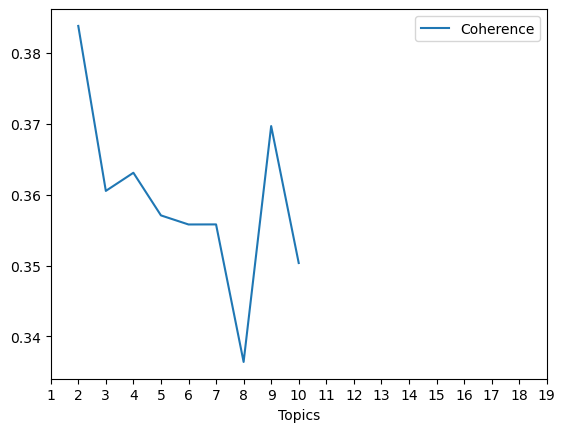

In [38]:
lda_tuning.plot(x ='Topics', y='Coherence', kind = 'line', xticks=range(1,20))

In [39]:
lda_tuning_best = lda_tuning.sort_values(by=['Coherence'], ascending=False).head(1)


tuned_topics = int(lda_tuning_best['Topics'].to_string(index=False))


# Since the values for Alpha and Beta can be float, symmetric and asymmetric, we will either strip or convert to float
try:
    tuned_alpha = float(lda_tuning_best['Alpha'].to_string(index=False))
except:
    tuned_alpha = lda_tuning_best['Alpha'].to_string(index=False).strip()
    

try:
    tuned_beta = float(lda_tuning_best['Beta'].to_string(index=False))
except:
    tuned_beta = lda_tuning_best['Beta'].to_string(index=False).strip()    
    
print(f'Best Parameters: Topics: {tuned_topics}, Alpha: {tuned_alpha}, Beta: {tuned_beta}')

Best Parameters: Topics: 2, Alpha: asymmetric, Beta: auto


In [41]:
%%time

tuned_lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       #num_topics=tuned_topics,
                       num_topics=9,
                       random_state=100,
                       passes=10,
                       alpha=tuned_alpha,
                       eta=tuned_beta,
                       workers = workers)

coherence_model_lda = CoherenceModel(model=tuned_lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
print('\nCoherence Score: ', coherence_model_lda)


Coherence Score:  Coherence_Measure(seg=<function s_one_set at 0x7fe23996fd00>, prob=<function p_boolean_sliding_window at 0x7fe23998c040>, conf=<function cosine_similarity at 0x7fe2399d4c10>, aggr=<function arithmetic_mean at 0x7fe2399d52d0>)
CPU times: user 6min 21s, sys: 3min 31s, total: 9min 53s
Wall time: 6min 6s


In [42]:
%%time

lda_display = gensimvis.prepare(tuned_lda_model, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)


CPU times: user 3min 39s, sys: 3min 20s, total: 6min 59s
Wall time: 54.5 s
